To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
  <a href="https://ko-fi.com/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a></a> Join Discord if you need help + support us if you can!
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://github.com/unslothai/unsloth#installation-instructions---conda).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save) (eg for Llama.cpp).

In [1]:
import torch
major_version, minor_version = torch.cuda.get_device_capability()

# %%
import os
import pandas as pd
import numpy as np
# os.environ["WANDB_DISABLED"] = "true"

# %%
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+


# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.1-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.2-bnb-4bit",
    "unsloth/llama-2-7b-bnb-4bit",
    "unsloth/llama-2-13b-bnb-4bit",
    "unsloth/codellama-34b-bnb-4bit",
    "unsloth/tinyllama-bnb-4bit",
]

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen2-7B-bnb-4bit",
    # model_name = "unsloth/tinyllama-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = True,

)



🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth: Fast Qwen2 patching release 2024.5
   \\   /|    GPU: NVIDIA GeForce RTX 3090. Max memory: 23.999 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 8.6. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.26.post1. FA = True.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
unsloth/Qwen2-7B-bnb-4bit does not have a padding token! Will use pad_token = <|PAD_TOKEN|>.


* We support Llama, Mistral, CodeLlama, TinyLlama, Vicuna, Open Hermes etc
* And Yi, Qwen ([llamafied](https://huggingface.co/models?sort=trending&search=qwen+llama)), Deepseek, all Llama, Mistral derived archs.
* We support 16bit LoRA or 4bit QLoRA. Both 2x faster.
* `max_seq_length` can be set to anything, since we do automatic RoPE Scaling via [kaiokendev's](https://kaiokendev.github.io/til) method.
* [**NEW**] With [PR 26037](https://github.com/huggingface/transformers/pull/26037), we support downloading 4bit models **4x faster**! [Our repo](https://huggingface.co/unsloth) has Llama, Mistral 4bit models.

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [2]:
import torch
import torch.nn as nn
from peft.tuners.lora import LoraLayer

def new_reset_lora_parameters(self, adapter_name, init_lora_weights):
    if init_lora_weights is False:
        return

    if adapter_name in self.lora_A.keys():
        if init_lora_weights is True:
            with torch.no_grad():
                # Method 1: QR decomposition of a random matrix
                print(f"Initializing {adapter_name} with QR decomposition of a random matrix")
                r = self.r[adapter_name]
                m = self.in_features
                n = self.out_features
                X = torch.randn(r, r)
                Q, _ = torch.linalg.qr(X)
                set1 = Q[0::2, :]  # Odd rows
                set2 = Q[1::2, :]  # Even rows
                a_wt = torch.randn(m, r // 2).mm(set1).to(torch.bfloat16).T / 50.0
                b_wt = torch.randn(r // 2, n).T.mm(set2).to(torch.bfloat16) / 50.0


                self.lora_A[adapter_name].weight = nn.Parameter(a_wt.contiguous())
                self.lora_B[adapter_name].weight = nn.Parameter(b_wt.contiguous())
        elif init_lora_weights.lower() == "gaussian":
            nn.init.normal_(self.lora_A[adapter_name].weight, std=1 / self.r[adapter_name])
            nn.init.zeros_(self.lora_B[adapter_name].weight)
        else:
            raise ValueError(f"Unknown initialization {init_lora_weights=}")
    if adapter_name in self.lora_embedding_A.keys():
        # initialize a the same way as the default for nn.linear and b to zero
        nn.init.zeros_(self.lora_embedding_A[adapter_name])
        nn.init.normal_(self.lora_embedding_B[adapter_name])

# Monkey patch the method
LoraLayer.reset_lora_parameters = new_reset_lora_parameters

In [3]:
from peft import LoftQConfig
model = FastLanguageModel.get_peft_model(
    model,
    r = 32, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = [
        # "lm_head",
        "q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = True,  # We support rank stabilized LoRA
    # init_lora_weights = 'loftq',
    # loftq_config = LoftQConfig(loftq_bits = 4, loftq_iter = 1), # And LoftQ
)
print("trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Initializing default with QR decomposition of a random matrix
Initializing default with QR decomposition of a random matrix
Initializing default with QR decomposition of a random matrix
Initializing default with QR decomposition of a random matrix
Initializing default with QR decomposition of a random matrix
Initializing default with QR decomposition of a random matrix
Initializing default with QR decomposition of a random matrix
Initializing default with QR decomposition of a random matrix
Initializing default with QR decomposition of a random matrix
Initializing default with QR decomposition of a random matrix
Initializing default with QR decomposition of a random matrix
Initializing default with QR decomposition of a random matrix
Initializing default with QR decomposition of a random matrix
Initializing default with QR decomposition of a random matrix
Initializing default with QR decomposition of a random matrix
Initializing default with QR decomposition of a random matrix
Initiali

Unsloth 2024.5 patched 28 layers with 0 QKV layers, 28 O layers and 28 MLP layers.


Initializing default with QR decomposition of a random matrix
Initializing default with QR decomposition of a random matrix
Initializing default with QR decomposition of a random matrix
Initializing default with QR decomposition of a random matrix
Initializing default with QR decomposition of a random matrix
Initializing default with QR decomposition of a random matrix
Initializing default with QR decomposition of a random matrix
Initializing default with QR decomposition of a random matrix
Initializing default with QR decomposition of a random matrix
Initializing default with QR decomposition of a random matrix
Initializing default with QR decomposition of a random matrix
Initializing default with QR decomposition of a random matrix
Initializing default with QR decomposition of a random matrix
Initializing default with QR decomposition of a random matrix
Initializing default with QR decomposition of a random matrix
Initializing default with QR decomposition of a random matrix
Initiali

<a name="Data"></a>
### Data Prep
We now use the Alpaca dataset from [yahma](https://huggingface.co/datasets/yahma/alpaca-cleaned), which is a filtered version of 52K of the original [Alpaca dataset](https://crfm.stanford.edu/2023/03/13/alpaca.html). You can replace this code section with your own data prep.

**[NOTE]** To train only on completions (ignoring the user's input) read TRL's docs [here](https://huggingface.co/docs/trl/sft_trainer#train-on-completions-only).

**[NOTE]** Remember to add the **EOS_TOKEN** to the tokenized output!! Otherwise you'll get infinite generations!

In [4]:
from datasets import load_dataset
from trl import SFTTrainer

In [5]:
import pandas as pd
import numpy as np


import os
cwd = os.getcwd()
kaggle = cwd == "/kaggle/working"
input_dir = "/kaggle/input/tweets/twitter-datasets/twitter-datasets/" if kaggle else "data/twitter-datasets/twitter-datasets/"
output_dir = "/kaggle/working/" if kaggle else "data/"

In [6]:
# import pandas as pd
# import numpy as np

# # load train_neg.txt and train_pos.txt with no delimiter
# train_neg_lines = open(input_dir+'train_neg.txt').read().splitlines()
# train_pos_lines = open(input_dir+'train_pos.txt').read().splitlines()

# # convert them to list
# train_neg = np.array(train_neg_lines)
# train_pos = np.array(train_pos_lines)

# # convert them to df
# train_neg_df = pd.DataFrame(train_neg, columns=['text'])
# train_neg_df['label'] = 0
# train_pos_df = pd.DataFrame(train_pos, columns=['text'])
# train_pos_df['label'] = 1

# # combine train_neg_df and train_pos_df
# df = pd.concat([train_neg_df, train_pos_df], ignore_index=True)
# df = df.sample(frac=1,random_state=42).reset_index(drop=True)
# df.to_csv(output_dir+'data.csv', index=False)
# df

In [24]:


data = pd.read_csv(output_dir + "data.csv")

from sklearn.model_selection import train_test_split

# keep a subset (for testing)
data = data.sample(frac=1, random_state=42)

train_df, val_df = train_test_split(data, test_size=0.5, random_state=42)
# save to output_dir
train_df.to_csv(output_dir + "train.csv", index=False)

(array([ 79., 254., 491., 375., 472., 505., 317., 402., 282., 270., 449.,
        264., 312., 180., 106., 116.,  38.,  32.,  16.,  13.,  11.,   3.,
          4.,   2.,   2.,   3.,   0.,   0.,   1.,   1.]),
 array([ 3. ,  5.4,  7.8, 10.2, 12.6, 15. , 17.4, 19.8, 22.2, 24.6, 27. ,
        29.4, 31.8, 34.2, 36.6, 39. , 41.4, 43.8, 46.2, 48.6, 51. , 53.4,
        55.8, 58.2, 60.6, 63. , 65.4, 67.8, 70.2, 72.6, 75. ]),
 <BarContainer object of 30 artists>)

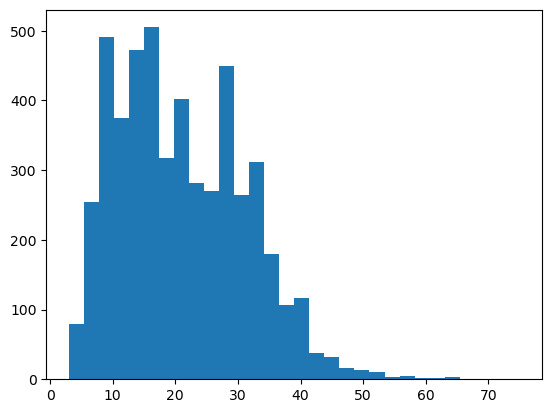

In [8]:
token_counts = [len(tokenizer.encode(x)) for x in train_df.text]
# plot the token counts
import matplotlib.pyplot as plt
plt.hist(token_counts, bins=30)

In [9]:
dataset = load_dataset(output_dir,data_files="train.csv", split="train")
dataset

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['text', 'label'],
    num_rows: 5000
})

In [10]:
prompt = """
Consider this tweet:
{}

Does this tweet have a positive sentiment?
The correct answer is:{}
""".strip()




def formatting_prompts_func(dataset_):
    if isinstance(dataset_['text'], str):
        return [""]
    texts = []
    for i in range(len(dataset_['text'])):
        # PROMPT 1:
        label = "Yes" if dataset_['label'][i] == 1 else "No"
        text = prompt.format(dataset_['text'][i], label)


        texts.append(text)
    return texts


response_template = "The correct answer is:"
from trl import DataCollatorForCompletionOnlyLM
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)


<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [11]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    # dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 32,
        gradient_accumulation_steps = 1,
        warmup_steps = 5,
        # max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        output_dir = "outputs",
        num_train_epochs = 1,
        report_to = "none",
        group_by_length = True,
    ),
    formatting_func=formatting_prompts_func,
    data_collator=collator,
)

Map (num_proc=2):   0%|          | 0/5000 [00:00<?, ? examples/s]

In [12]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 3090. Max memory = 23.999 GB.
7.344 GB of memory reserved.


In [13]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 5,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 32 | Gradient Accumulation steps = 1
\        /    Total batch size = 32 | Total steps = 157
 "-____-"     Number of trainable parameters = 80,740,352


Step,Training Loss
1,9.496000
2,9.511600
3,3.888000
4,0.828400
5,0.512500
6,2.998100
7,0.574300
8,3.355000
9,0.797300
10,0.594900


In [14]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

221.8901 seconds used for training.
3.7 minutes used for training.
Peak reserved memory = 10.754 GB.
Peak reserved memory for training = 3.41 GB.
Peak reserved memory % of max memory = 44.81 %.
Peak reserved memory for training % of max memory = 14.209 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

In [15]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

In [28]:
from collections import defaultdict

# Step 1: Tokenize the inputs and sort them by their tokenized length
tokenized_inputs = []
for i in range(len(val_df['text'])):
    test_str = prompt.format(val_df['text'].iloc[i], "")
    tokenized_input = tokenizer(test_str, return_tensors="pt", add_special_tokens=False)
    tokenized_inputs.append((tokenized_input, test_str, val_df['label'].iloc[i]))

# Sort by tokenized length
tokenized_inputs.sort(key=lambda x: x[0]['input_ids'].shape[1])

# Step 2: Group the inputs by their tokenized length
grouped_inputs = defaultdict(list)
for tokenized_input, test_str, label in tokenized_inputs:
    length = tokenized_input['input_ids'].shape[1]
    grouped_inputs[length].append((tokenized_input, test_str, label))

# Step 3: Process each group in batches of 64
batch_size = 64
all_outputs = []
all_labels = []

for length, group in grouped_inputs.items():
    for i in range(0, len(group), batch_size):
        batch = group[i:i+batch_size]
        batch_inputs = [item[0] for item in batch]
        batch_strings = [item[1] for item in batch]
        batch_labels = [item[2] for item in batch]

        # Concatenate the batch inputs
        input_ids = torch.cat([item['input_ids'] for item in batch_inputs], dim=0).to("cuda")
        attention_mask = torch.cat([item['attention_mask'] for item in batch_inputs], dim=0).to("cuda")

        # Generate outputs
        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_new_tokens=1, use_cache=True, pad_token_id=tokenizer.eos_token_id)
        decoded_outputs = tokenizer.batch_decode(outputs)

        all_outputs.extend(decoded_outputs)
        all_labels.extend(batch_labels)

# Step 4: Do the label assignment
correct = 0
total = 0

for i in range(len(all_outputs)):
    output = all_outputs[i]
    pred = output[-3:]  # take the pred from the output
    pred = str(1 if pred == "Yes" else 0)
    label = str(all_labels[i])
    output = output + " pred: " + pred + " label: " + label
    if i < 25:
        print(f"{i}: {output}")

    if pred == label:
        correct += 1
    total += 1

print(f"Correct: {correct} Total: {total} Accuracy: {correct/total}")

0: Consider this tweet:
please

Does this tweet have a positive sentiment?
The correct answer is:No pred: 0 label: 0
1: Consider this tweet:
awe she called

Does this tweet have a positive sentiment?
The correct answer is:Yes pred: 1 label: 1
2: Consider this tweet:
out of church

Does this tweet have a positive sentiment?
The correct answer is:No pred: 0 label: 1
3: Consider this tweet:
walking to school

Does this tweet have a positive sentiment?
The correct answer is:Yes pred: 1 label: 0
4: Consider this tweet:
this fever tho

Does this tweet have a positive sentiment?
The correct answer is:No pred: 0 label: 0
5: Consider this tweet:
this is bad

Does this tweet have a positive sentiment?
The correct answer is:No pred: 0 label: 0
6: Consider this tweet:
really good night

Does this tweet have a positive sentiment?
The correct answer is:Yes pred: 1 label: 1
7: Consider this tweet:
bye my twitter

Does this tweet have a positive sentiment?
The correct answer is:No pred: 0 label: 0
8: 

In [43]:
# load test_data.txt and turn it into a df
test_lines = open(input_dir+'test_data.txt').read().splitlines() # id,text
test = np.array(test_lines)
test_df = pd.DataFrame(test, columns=['text'])
test_df.index.name = 'Id'
# test_df = test_df.iloc[:100]
test_df # Id, text

,text
Id,
0,"1,sea doo pro sea scooter ( sports with the po..."
1,"2,<user> shucks well i work all week so now i ..."
2,"3,i cant stay away from bug thats my baby"
3,"4,<user> no ma'am ! ! ! lol im perfectly fine ..."
4,"5,whenever i fall asleep watching the tv , i a..."
...,...
9995,"9996,had a nice time w / my friend lastnite"
9996,"9997,<user> no it's not ! please stop !"
9997,"9998,not without my daughter ( dvd two-time os..."


In [44]:
submission_df = pd.read_csv(input_dir+'sample_submission.csv',index_col=0)
# submission_df = submission_df.iloc[:100]
submission_df # Id, Prediction

,Prediction
Id,
1,1
2,1
3,1
4,1
5,1
...,...
9996,-1
9997,1
9998,-1


In [45]:
# Step 5: Make predictions on the test data
# Tokenize the test inputs and sort them by their tokenized length
test_tokenized_inputs = []
for i in range(len(test_df['text'])):
    test_str = prompt.format(test_df['text'].iloc[i], "")
    tokenized_input = tokenizer(test_str, return_tensors="pt", add_special_tokens=False)
    test_tokenized_inputs.append((tokenized_input, test_str, i))

# Sort by tokenized length
test_tokenized_inputs.sort(key=lambda x: x[0]['input_ids'].shape[1])

# Group the test inputs by their tokenized length
test_grouped_inputs = defaultdict(list)
for tokenized_input, test_str, idx in test_tokenized_inputs:
    length = tokenized_input['input_ids'].shape[1]
    test_grouped_inputs[length].append((tokenized_input, test_str, idx))

# Process each test group in batches of 64
test_batch_size = 64
test_outputs = []
test_indices = []

for length, group in test_grouped_inputs.items():
    for i in range(0, len(group), test_batch_size):
        batch = group[i:i+test_batch_size]
        batch_inputs = [item[0] for item in batch]
        batch_strings = [item[1] for item in batch]
        batch_indices = [item[2] for item in batch]

        # Concatenate the batch inputs
        input_ids = torch.cat([item['input_ids'] for item in batch_inputs], dim=0).to("cuda")
        attention_mask = torch.cat([item['attention_mask'] for item in batch_inputs], dim=0).to("cuda")

        # Generate outputs
        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_new_tokens=1, use_cache=True, pad_token_id=tokenizer.eos_token_id)
        decoded_outputs = tokenizer.batch_decode(outputs)

        test_outputs.extend(decoded_outputs)
        test_indices.extend(batch_indices)

# Step 6: Assign predictions to the test DataFrame
test_predictions = []
for output in test_outputs:
    pred = output[-3:]  # take the pred from the output
    pred = str(1 if pred == "Yes" else 0)
    test_predictions.append(pred)

# Ensure the predictions are sorted by their original index
sorted_predictions = [x for _, x in sorted(zip(test_indices, test_predictions))]

# Step 7: Create the submission DataFrame
submission_df['Prediction'] = sorted_predictions
submission_df.to_csv('submission.csv')

print("Submission file created: submission.csv")

Submission file created: submission.csv


 You can also use a `TextStreamer` for continuous inference - so you can see the generation token by token, instead of waiting the whole time!

In [46]:
# # alpaca_prompt = Copied from above
# FastLanguageModel.for_inference(model) # Enable native 2x faster inference
# inputs = tokenizer(
# [
#     alpaca_prompt.format(
#         "Continue the fibonnaci sequence.", # instruction
#         "1, 1, 2, 3, 5, 8", # input
#         "", # output - leave this blank for generation!
#     )
# ], return_tensors = "pt").to("cuda")

# from transformers import TextStreamer
# text_streamer = TextStreamer(tokenizer)
# _ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [47]:
model.save_pretrained("lora_model") # Local saving
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [48]:
# if False:
#     from unsloth import FastLanguageModel
#     model, tokenizer = FastLanguageModel.from_pretrained(
#         model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
#         max_seq_length = max_seq_length,
#         dtype = dtype,
#         load_in_4bit = load_in_4bit,
#     )
#     FastLanguageModel.for_inference(model) # Enable native 2x faster inference

# # alpaca_prompt = You MUST copy from above!

# inputs = tokenizer(
# [
#     alpaca_prompt.format(
#         "What is a famous tall tower in Paris?", # instruction
#         "", # input
#         "", # output - leave this blank for generation!
#     )
# ], return_tensors = "pt").to("cuda")

# outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
# tokenizer.batch_decode(outputs)

You can also use Hugging Face's `AutoModelForPeftCausalLM`. Only use this if you do not have `unsloth` installed. It can be hopelessly slow, since `4bit` model downloading is not supported, and Unsloth's **inference is 2x faster**.

In [49]:
# if False:
#     # I highly do NOT suggest - use Unsloth if possible
#     from peft import AutoModelForPeftCausalLM
#     from transformers import AutoTokenizer
#     model = AutoModelForPeftCausalLM.from_pretrained(
#         "lora_model", # YOUR MODEL YOU USED FOR TRAINING
#         load_in_4bit = load_in_4bit,
#     )
#     tokenizer = AutoTokenizer.from_pretrained("lora_model")

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [50]:
# Merge to 16bit
# model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
# model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False: model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "lora", token = "")

### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

In [51]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

Now, use the `model-unsloth.gguf` file or `model-unsloth-Q4_K_M.gguf` file in `llama.cpp` or a UI based system like `GPT4All`. You can install GPT4All by going [here](https://gpt4all.io/index.html).

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/u54VK8m8tk) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Zephyr DPO 2x faster [free Colab](https://colab.research.google.com/drive/15vttTpzzVXv_tJwEk-hIcQ0S9FcEWvwP?usp=sharing)
2. Llama 7b 2x faster [free Colab](https://colab.research.google.com/drive/1lBzz5KeZJKXjvivbYvmGarix9Ao6Wxe5?usp=sharing)
3. TinyLlama 4x faster full Alpaca 52K in 1 hour [free Colab](https://colab.research.google.com/drive/1AZghoNBQaMDgWJpi4RbffGM1h6raLUj9?usp=sharing)
4. CodeLlama 34b 2x faster [A100 on Colab](https://colab.research.google.com/drive/1y7A0AxE3y8gdj4AVkl2aZX47Xu3P1wJT?usp=sharing)
5. Llama 7b [free Kaggle](https://www.kaggle.com/danielhanchen/unsloth-alpaca-t4-ddp)
6. We also did a [blog](https://huggingface.co/blog/unsloth-trl) with 🤗 HuggingFace, and we're in the TRL [docs](https://huggingface.co/docs/trl/main/en/sft_trainer#accelerate-fine-tuning-2x-using-unsloth)!

<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://ko-fi.com/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a></a> Support our work if you can! Thanks!
</div>